In [2]:
# Let's outline and begin building a step-by-step modular project for Inbound Supply Chain Forecasting

# === Step 1: Setup & Data Preparation ===
# This includes importing libraries, setting up the environment, and generating the synthetic dataset

# Module: setup_and_data_prep.py

# Imports
import pandas as pd
import numpy as np

# Function to generate synthetic data
def generate_synthetic_inbound_data(start_date='2022-01-01', end_date='2024-12-31'):
    np.random.seed(101)
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    n_days = len(date_range)

    weekly = 100 + 30 * np.sin(2 * np.pi * np.arange(n_days) / 7)
    annual = 20 * np.sin(2 * np.pi * np.arange(n_days) / 365.25)
    trend = np.linspace(0, 50, n_days)
    noise = np.random.normal(0, 15, n_days)

    days_of_week = pd.Series(date_range.dayofweek)
    month = pd.Series(date_range.month)

    event_effect = ((month == 11) | (month == 12)) * np.random.randint(10, 50, size=n_days)
    disruption = ((month == 3) & (days_of_week == 2)) * -np.random.randint(10, 30, size=n_days)

    volume = weekly + annual + trend + noise + event_effect + disruption

    df = pd.DataFrame({
        'date': date_range,
        'inbound_volume': np.round(volume, 2),
        'is_peak_season': ((month == 11) | (month == 12)).astype(int),
        'is_disruption': (((month == 3) & (days_of_week == 2)).astype(int))
    })

    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    return df

# Generate and display first 30 rows
synthetic_data = generate_synthetic_inbound_data()



In [4]:
synthetic_data.head()

,date,inbound_volume,is_peak_season,is_disruption,day_of_week,month
0,2022-01-01,140.60,0,0,5,1
1,2022-01-02,133.27,0,0,6,1
2,2022-01-03,143.65,0,0,0,1
3,2022-01-04,121.74,0,0,1,1
4,2022-01-05,98.31,0,0,2,1


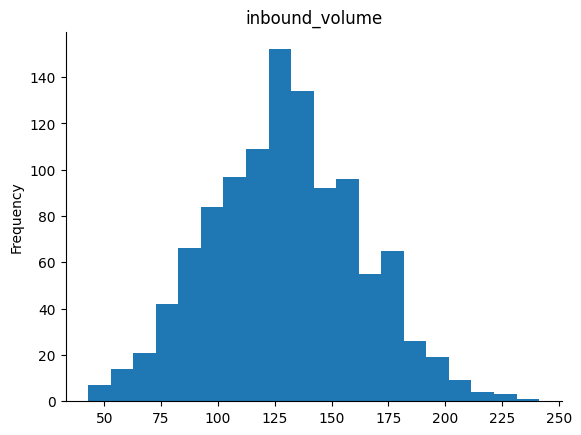

In [5]:
# @title inbound_volume

from matplotlib import pyplot as plt
synthetic_data['inbound_volume'].plot(kind='hist', bins=20, title='inbound_volume')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [6]:
# === Step 2: Data Cleaning & Feature Engineering ===

# Function to clean and engineer features
def clean_and_engineer_features(df):
    df = df.copy()

    # Ensure correct types
    df['date'] = pd.to_datetime(df['date'])
    df['inbound_volume'] = pd.to_numeric(df['inbound_volume'])

    # Lag features
    df['lag_1'] = df['inbound_volume'].shift(1)
    df['lag_7'] = df['inbound_volume'].shift(7)

    # Rolling statistics
    df['rolling_mean_7'] = df['inbound_volume'].rolling(window=7).mean()
    df['rolling_std_7'] = df['inbound_volume'].rolling(window=7).std()

    # Cyclical encoding
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Drop rows with NA due to lag/rolling
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

# Apply the function to synthetic data
processed_data = clean_and_engineer_features(synthetic_data)




In [8]:
processed_data.head()

,date,inbound_volume,is_peak_season,is_disruption,day_of_week,month,lag_1,lag_7,rolling_mean_7,rolling_std_7,day_of_week_sin,day_of_week_cos,month_sin,month_cos
0,2022-01-08,111.81,0,0,5,1,66.16,140.60,106.121429,30.385813,-0.974928,-0.222521,0.5,0.866025
1,2022-01-09,96.29,0,0,6,1,111.81,133.27,100.838571,28.000112,-0.781831,0.623490,0.5,0.866025
2,2022-01-10,143.84,0,0,0,1,96.29,143.65,100.865714,28.048580,0.000000,1.000000,0.5,0.866025
3,2022-01-11,124.83,0,0,1,1,143.84,121.74,101.307143,28.453249,0.781831,0.623490,0.5,0.866025
4,2022-01-12,82.41,0,0,2,1,124.83,98.31,99.035714,29.352818,0.974928,-0.222521,0.5,0.866025


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# === Step 3: Linear Regression Baseline Model ===

# Define features and target
feature_cols = [
    'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7',
    'day_of_week_sin', 'day_of_week_cos',
    'month_sin', 'month_cos',
    'is_peak_season', 'is_disruption'
]
target_col = 'inbound_volume'

X = processed_data[feature_cols]
y = processed_data[target_col]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Fit Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred = lr_model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Collect predictions in a DataFrame
results_df = processed_data.iloc[y_test.index][['date', 'inbound_volume']].copy()
results_df['predicted_volume'] = y_pred
results_df['error'] = results_df['inbound_volume'] - results_df['predicted_volume']
results_df['abs_error'] = results_df['error'].abs()



In [10]:
results_df.head(30)

,date,inbound_volume,predicted_volume,error,abs_error
871,2024-05-28,192.59,164.996549,27.593451,27.593451
872,2024-05-29,149.13,139.129545,10.000455,10.000455
873,2024-05-30,126.66,126.126959,0.533041,0.533041
874,2024-05-31,139.58,132.738647,6.841353,6.841353
875,2024-06-01,142.66,155.867193,-13.207193,13.207193
876,2024-06-02,180.86,180.824847,0.035153,0.035153
877,2024-06-03,176.32,184.947008,-8.627008,8.627008
878,2024-06-04,154.41,164.232907,-9.822907,9.822907
879,2024-06-05,140.31,137.451306,2.858694,2.858694
880,2024-06-06,118.08,119.021371,-0.941371,0.941371


In [11]:
import xgboost as xgb

# === Step 4: XGBoost Model Training and Evaluation ===

# Prepare data (using same train/test split as before)
X_train_xgb, X_test_xgb = X_train.copy(), X_test.copy()
y_train_xgb, y_test_xgb = y_train.copy(), y_test.copy()

# Define and train XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train_xgb, y_train_xgb)

# Predict
y_pred_xgb = xgb_model.predict(X_test_xgb)

# Evaluate
mae_xgb = mean_absolute_error(y_test_xgb, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb))

# Collect predictions in a DataFrame
results_xgb = processed_data.iloc[y_test_xgb.index][['date', 'inbound_volume']].copy()
results_xgb['predicted_volume_xgb'] = y_pred_xgb
results_xgb['error'] = results_xgb['inbound_volume'] - results_xgb['predicted_volume_xgb']
results_xgb['abs_error'] = results_xgb['error'].abs()



In [12]:
results_xgb.head(30)

,date,inbound_volume,predicted_volume_xgb,error,abs_error
871,2024-05-28,192.59,164.350342,28.239658,28.239658
872,2024-05-29,149.13,141.016144,8.113856,8.113856
873,2024-05-30,126.66,119.757431,6.902569,6.902569
874,2024-05-31,139.58,143.636719,-4.056719,4.056719
875,2024-06-01,142.66,156.552551,-13.892551,13.892551
876,2024-06-02,180.86,167.453644,13.406356,13.406356
877,2024-06-03,176.32,174.224915,2.095085,2.095085
878,2024-06-04,154.41,156.548004,-2.138004,2.138004
879,2024-06-05,140.31,139.577469,0.732531,0.732531
880,2024-06-06,118.08,117.516434,0.563566,0.563566


In [16]:
# Compare performance of Linear Regression vs XGBoost

# Calculate metrics for both models
mae_lr = mean_absolute_error(y_test, lr_model.predict(X_test))
rmse_lr = np.sqrt(mean_squared_error(y_test, lr_model.predict(X_test)))

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'XGBoost'],
    'MAE': [mae_lr, mae_xgb],
    'RMSE': [rmse_lr, rmse_xgb]
})
comparison_df.head()

,Model,MAE,RMSE
0,Linear Regression,12.112545,15.401901
1,XGBoost,12.999457,16.313739


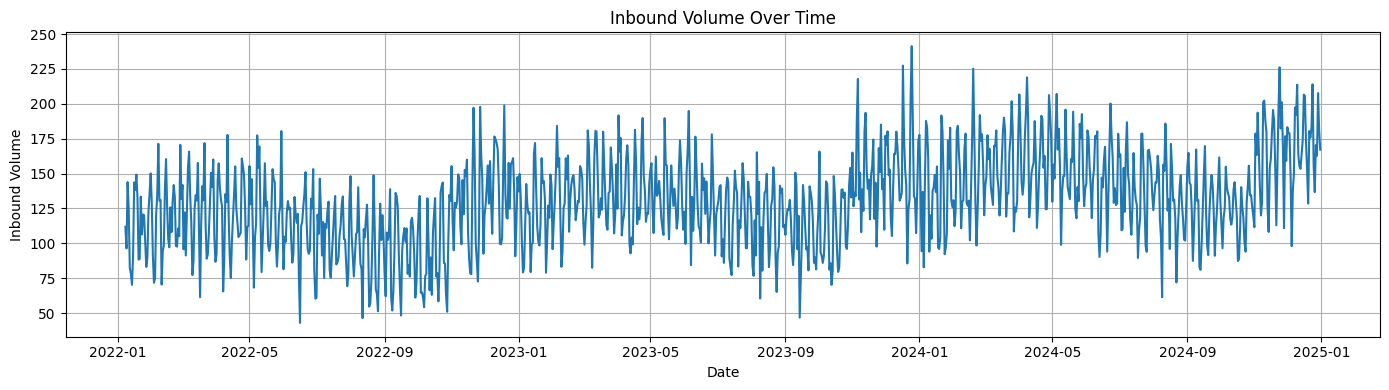

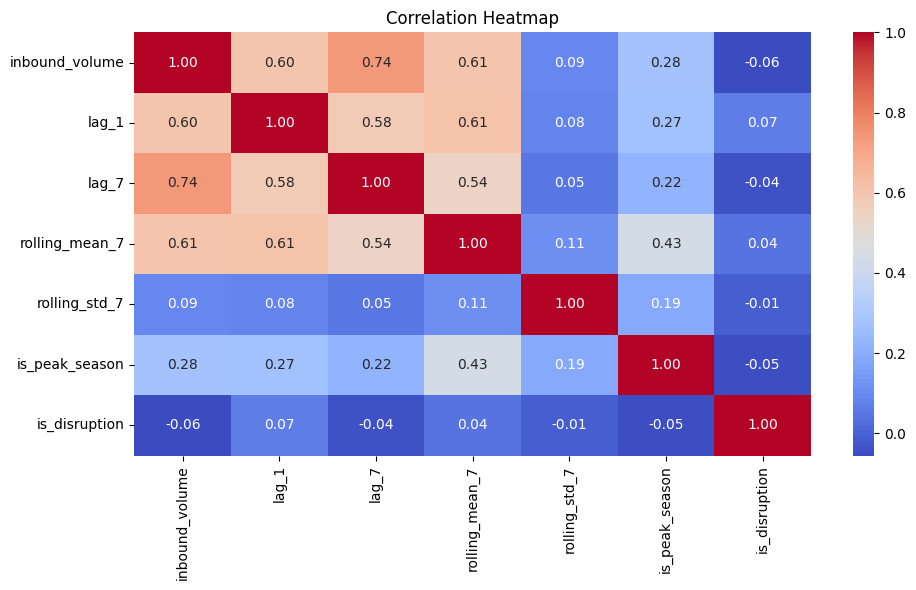

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# === Step 5: Explore Data Linearity and Structure ===

# 1. Plot inbound volume over time
plt.figure(figsize=(14, 4))
plt.plot(processed_data['date'], processed_data['inbound_volume'])
plt.title('Inbound Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Inbound Volume')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Correlation heatmap to detect linear relationships
correlation_matrix = processed_data[[
    'inbound_volume', 'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7',
    'is_peak_season', 'is_disruption'
]].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


In [18]:
pip install prophet


In [19]:
from prophet import Prophet

# === Step 6: Prophet Model ===

# Prepare data for Prophet
prophet_data = processed_data[['date', 'inbound_volume']].rename(columns={
    'date': 'ds',
    'inbound_volume': 'y'
})

# Initialize Prophet model
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='additive'  # can try 'multiplicative' for high variance
)

# Fit the model
prophet_model.fit(prophet_data)

# Create a future dataframe for next 90 days
future = prophet_model.make_future_dataframe(periods=90)
forecast = prophet_model.predict(future)

# Select key forecast columns
forecast_result = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(90)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6j6jr5xr/w6c6s0fy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6j6jr5xr/opsx0s5s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89979', 'data', 'file=/tmp/tmp6j6jr5xr/w6c6s0fy.json', 'init=/tmp/tmp6j6jr5xr/opsx0s5s.json', 'output', 'file=/tmp/tmp6j6jr5xr/prophet_modelwsxod9al/prophet_model-20250629024706.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:47:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:47:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6j6jr5xr/a3l4i8ga.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6j6jr5xr/dbz97pv5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83073', 'data', 'file=/tmp/tmp6j6jr5xr/a3l4i8ga.json', 'init=/tmp/tmp6j6jr5xr/dbz97pv5.json', 'output', 'file=/tmp/tmp6j6jr5xr/prophet_model20wo541f/prophet_model-20250629024732.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:47:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:47:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


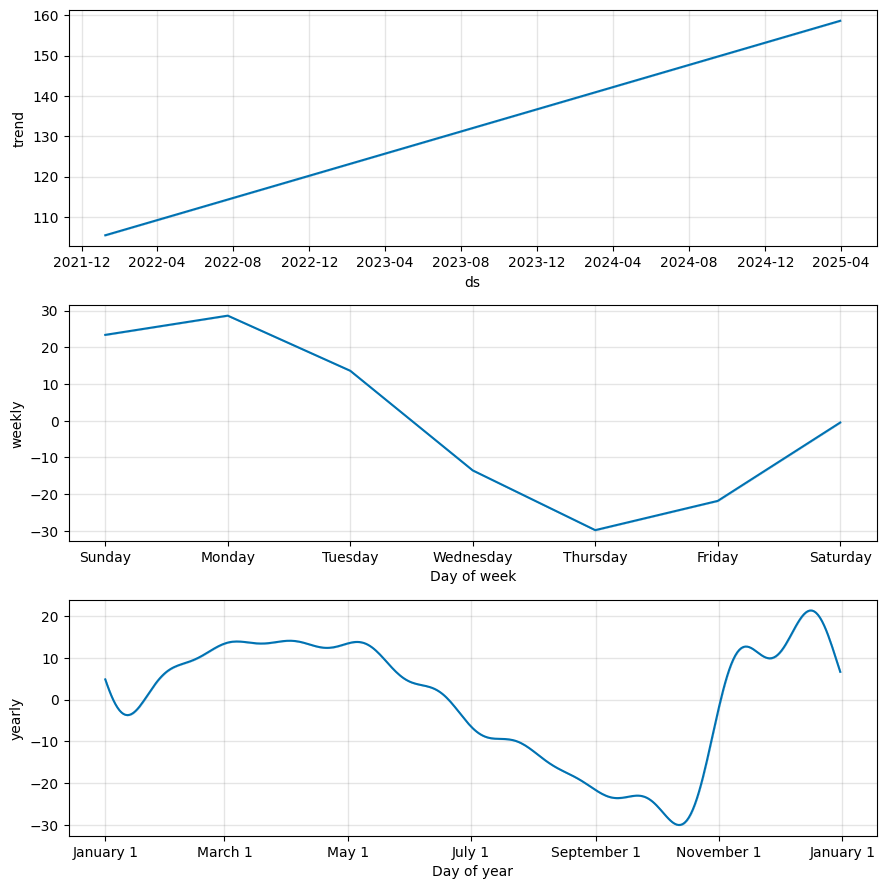

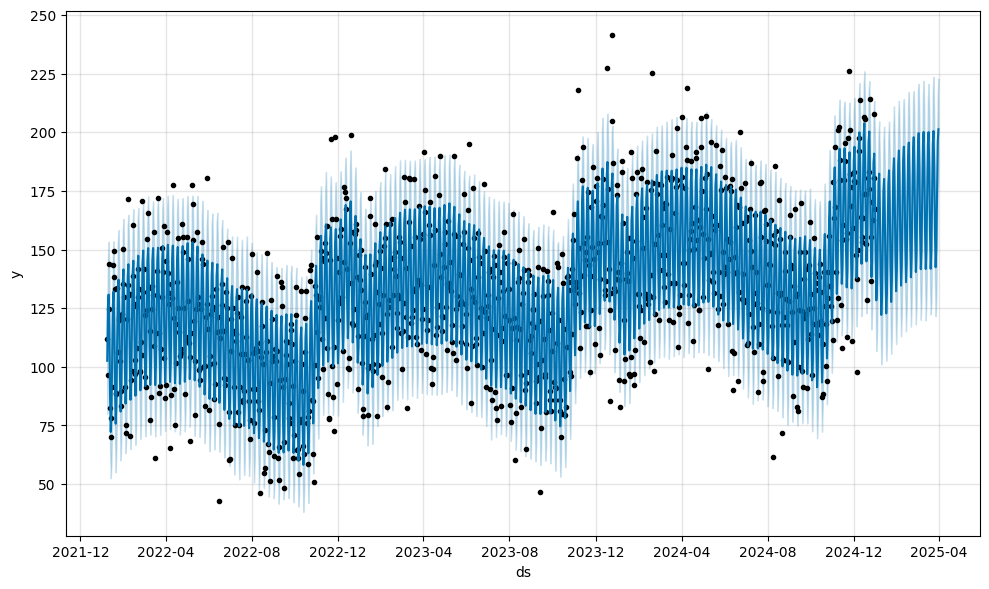

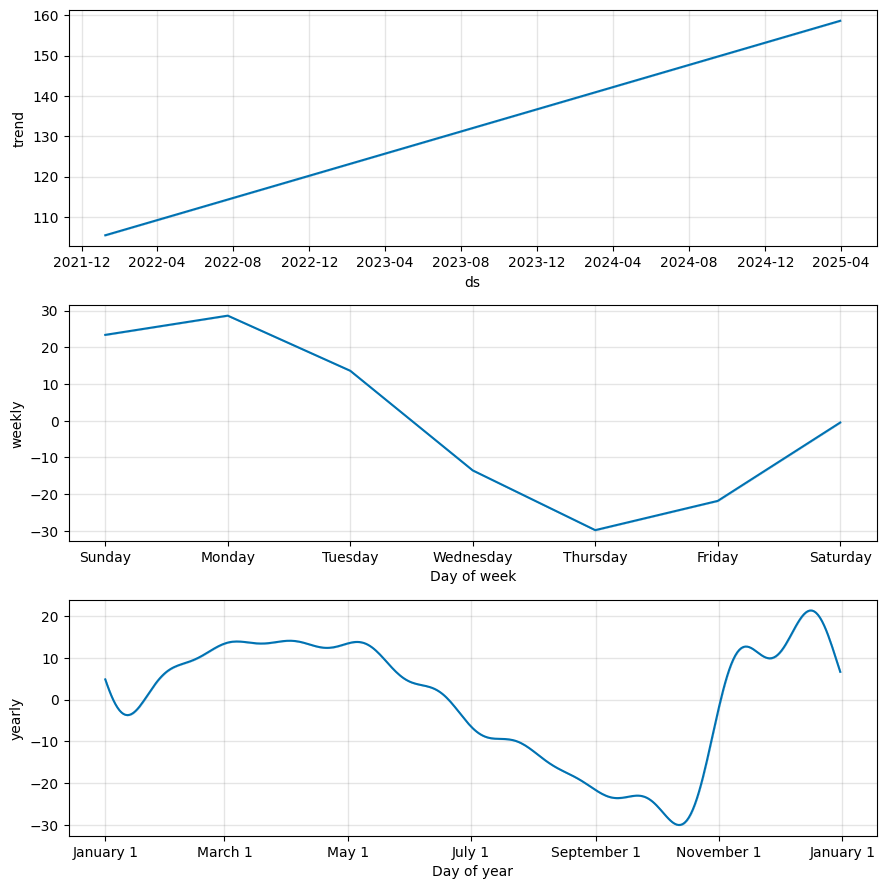

In [20]:
from prophet import Prophet
import pandas as pd

# 1. Prepare data
df = processed_data[['date', 'inbound_volume']].rename(columns={
    'date': 'ds', 'inbound_volume': 'y'
})

# 2. Initialize and fit model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.fit(df)

# 3. Create future timeline (e.g., 90 days)
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

# 4. Plot results
model.plot(forecast)
model.plot_components(forecast)


In [23]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Merge forecast and actuals (only for overlapping dates)
merged = df.merge(forecast[['ds', 'yhat']], on='ds')

# Calculate RMSE manually
mse = mean_squared_error(merged['y'], merged['yhat'])
rmse = np.sqrt(mse)
print(f"RMSE on training data: {rmse:.2f}")


RMSE on training data: 16.59


In [24]:
from sklearn.metrics import mean_squared_error
import numpy as np

# --- Prophet RMSE ---
# Merge Prophet forecast with actuals
prophet_merged = df.merge(forecast[['ds', 'yhat']], on='ds')

# RMSE for Prophet
mse_prophet = mean_squared_error(prophet_merged['y'], prophet_merged['yhat'])
rmse_prophet = np.sqrt(mse_prophet)

# --- Linear Regression RMSE ---
# Get predictions from linear model
y_pred_lr = lr_model.predict(X_test)

# RMSE for Linear Regression (already split into y_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

# --- Compare ---
print("📈 Model Performance Comparison:")
print(f"Linear Regression RMSE: {rmse_lr:.2f}")
print(f"Prophet RMSE: {rmse_prophet:.2f}")


📈 Model Performance Comparison:
Linear Regression RMSE: 15.40
Prophet RMSE: 16.59


In [28]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Assume df is already processed
data = processed_data[['inbound_volume']].copy()


# Normalize data
scaler = MinMaxScaler()
data['scaled'] = scaler.fit_transform(data[['inbound_volume']])

# Create sequences
def create_sequences(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

window_size = 14
X, y = create_sequences(data['scaled'].values, window_size)

# Reshape for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build LSTM
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(window_size, 1)),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Predict and evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(
    scaler.inverse_transform(y_test.reshape(-1, 1)),
    scaler.inverse_transform(y_pred)
))
print(f"LSTM RMSE: {rmse:.2f}")


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1348
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0247
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0230
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0243
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0222
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0225
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0221
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0223
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0209
Epoch 10/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0205


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
LSTM RMSE: 27.37
